In [3]:
import numpy as np
import pandas as pd

# Scikit-learn Kütüphaneleri
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import chi2, SelectKBest

# NLTK Kütüphaneleri
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer

# SpaCy Kütüphanesi
import spacy


In [4]:
!pip install contractions


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 6.1 MB/s eta 0:00:00


In [6]:
import os

# /kaggle/input altında hangi dosyalar var, listeleyelim
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv
/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv


dataset oluşturma

In [7]:
# Read the dataset with name "Emotion_classify_Data.csv" and store it in a variable df
columns = ['id','uygulama','duygu_durumu','metin']
df_train= pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv", names=columns)
df_validation = pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv", names=columns)

In [8]:
df_train.head(5)



,id,uygulama,duygu_durumu,metin
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [9]:
df_validation.head(5)

,id,uygulama,duygu_durumu,metin
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            74682 non-null  int64 
 1   uygulama      74682 non-null  object
 2   duygu_durumu  74682 non-null  object
 3   metin         73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [10]:
# Check the distribution of Emotion
df_train['duygu_durumu'].value_counts()

duygu_durumu
Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64

In [11]:
#örnek gözlemler
for i in range(100):
    if i%25==0:
        print(f"{i+1}: {df_train['metin'][i]} -> {df_train['duygu_durumu'][i]}")

1: im getting on borderlands and i will murder you all , -> Positive
26: The biggest disappointment of my life came a year ago. -> Negative
51: Guilty of sobriety! A bit of a borderline. I was called to work early tomorrow, so I can't catch up. -> Neutral
76: imma probably play live borderlands tps in a bit. that'll be fun -> Positive


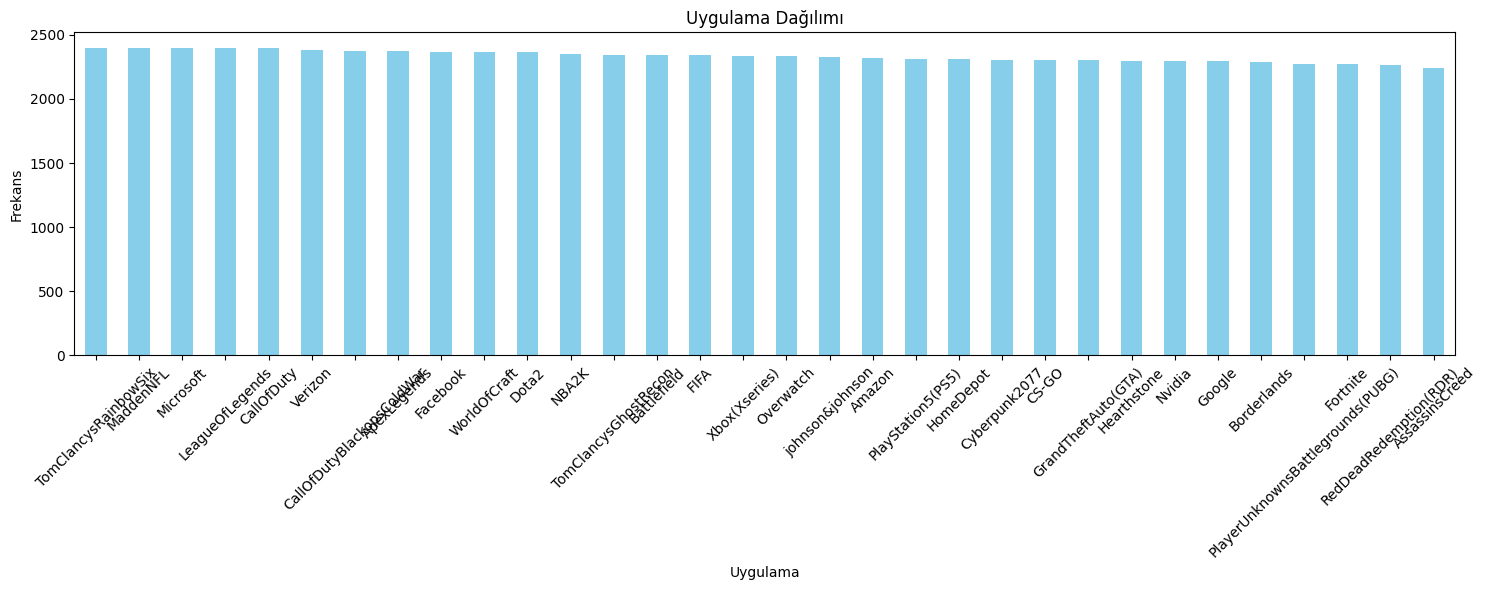

In [12]:
import matplotlib.pyplot as plt

# Uygulama sayımlarını al
uygulama_sayim = df_train['uygulama'].value_counts()

# Grafik çizimi
plt.figure(figsize=(15, 6))
uygulama_sayim.plot(kind='bar', color='skyblue')
plt.title('Uygulama Dağılımı')
plt.xlabel('Uygulama')
plt.ylabel('Frekans')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [13]:
#id nasıl bir değişken diye kontrol ettiğimizde daha çok bireye veya grupa ait olduğunu gözlemledik
df_train['id'].nunique()




12447

****PREPROCESSİNG İŞLEMLERİ****

In [14]:
# NLTK stopwords ve tokenizer
nltk.download('punkt')
nltk.download('stopwords')
nltk_stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


replace  urls and users :URL'ler ve kullanıcı adlarını tespit edip değiştirme 

In [15]:
import re
import pandas as pd

def replace_urls_and_users(text):
    if isinstance(text, str): 
        text = re.sub(r'https?://\S+|www\.\S+', 'URL', text)
        text = re.sub(r'@\w+', 'AT_USER', text)
        return text
    return text 

df_train['metin'] = df_train['metin'].astype(str).apply(replace_urls_and_users)
df_validation['metin'] = df_validation['metin'].astype(str).apply(replace_urls_and_users)

print(df_train['metin'].head(3))


0    im getting on borderlands and i will murder yo...
1    I am coming to the borders and I will kill you...
2    im getting on borderlands and i will kill you ...
Name: metin, dtype: object


Kısaltmaların Açılması (Contraction Replacement):“don’t” → “do not”, “can’t” → “can not” gibi.

Bu adım çalışmalarda uygulanmış ve olumsuzlukların doğru algılanmasına etki etmiştir.

In [16]:


import contractions

# Metindeki  kısaltmaları açan fonksiyon
def expand_with_library(text):
    return contractions.fix(text)


    
df_train['metin'] = df_train['metin'].astype(str).apply(expand_with_library)
df_validation['metin'] = df_validation['metin'].astype(str).apply(expand_with_library)

print(df_train['metin'].head(3))


0    i am getting on borderlands and i will murder ...
1    I am coming to the borders and I will kill you...
2    i am getting on borderlands and i will kill yo...
Name: metin, dtype: object


Küçük Harfe Dönüştürme (Lowercasing):“Good” ve “good” gibi aynı kelimenin farklı halleri tekilleştirilir.

In [17]:
# Metni küçük harfe dönüştürme işlemi
df_train['metin'] = df_train['metin'].str.lower()
df_validation['metin'] = df_validation['metin'].str.lower()


print(df_train['metin'].head(3))


0    i am getting on borderlands and i will murder ...
1    i am coming to the borders and i will kill you...
2    i am getting on borderlands and i will kill yo...
Name: metin, dtype: object


Sayıların Kaldırılması:genellikle duygu içermez; bu yüzden çıkarılır.

In [18]:
import re

# Sayıları kaldırma işlemi
df_train['metin'] = df_train['metin'].apply(lambda s: re.sub(r'\d+', '', str(s)))
df_validation['metin'] = df_validation['metin'].apply(lambda s: re.sub(r'\d+', '', str(s)))


print(df_train['metin'].head(3))


0    i am getting on borderlands and i will murder ...
1    i am coming to the borders and i will kill you...
2    i am getting on borderlands and i will kill yo...
Name: metin, dtype: object


Tekrarlanan noktalama işaretlerini tek örnekle değiştirme:"!!!” veya “???” gibi tekrar eden noktalama işaretleri özel etiketlerle değiştirilir.

In [19]:
df_train['metin'] = df_train['metin'].apply(lambda s: re.sub(r'([!?.,])\1+', r'\1', s))
df_validation['metin'] = df_validation['metin'].apply(lambda s: re.sub(r'([!?.,])\1+', r'\1', s))



print(df_train['metin'].head(3))


0    i am getting on borderlands and i will murder ...
1    i am coming to the borders and i will kill you...
2    i am getting on borderlands and i will kill yo...
Name: metin, dtype: object


noktalama işaretlerini kaldırma

In [20]:
df_train['metin'] = df_train['metin'].str.replace('[^\w\s]', '')
df_validation['metin'] = df_validation['metin'].str.replace('[^\w\s]', '')


print(df_train['metin'].head(3))


0    i am getting on borderlands and i will murder ...
1    i am coming to the borders and i will kill you...
2    i am getting on borderlands and i will kill yo...
Name: metin, dtype: object


Stopwords Kaldırma Ancak:“a”, “the”, “is” gibi anlamsız kelimeleri kaldırdık ancak “not”, “no” ve “never” gibi olumsuzluk içeren stopword’ler koruduk.

In [21]:

# 2. Negation kelimeleri (genişletilmiş set)
negations = {
    'not', 'no', 'never', 'none', 'cannot',
    'do not', 'does not', 'did not',
    'has not', 'have not', 'had not',
    'will not', 'would not', 'can not', 'should not',
    'might not', 'must not'
}

# 3. Stopwords listesinden negation'ları çıkar
stop_words = set(stopwords.words('english')) - negations

# 4. Metin üzerinde kelime bazlı stopword temizliği
df_train['metin'] = df_train['metin'].apply(
    lambda text: ' '.join([word.lower() for word in text.split() if word.lower() not in stop_words])
)
df_validation['metin'] = df_validation['metin'].apply(
    lambda text: ' '.join([word.lower() for word in text.split() if word.lower() not in stop_words])
)

Tokenizasyon:Metin, kelime veya sembol bazlı parçalara ayrılır (kelimelere bölme işlemidir).

In [22]:
import contractions
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# 2. Tokenizasyon (kısaltmalar açıldıktan sonra yapılmalı!)
df_train['tokens'] = df_train['metin'].apply(word_tokenize)
df_validation['tokens'] = df_validation['metin'].apply(word_tokenize)


Lemmatization:Kelimeler kök hallerine indirdik (örn. “playing”, “played” → “play”).

In [24]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag

# Gerekli dosyaları indir (sadece ilk çalıştırmada gerekli)
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

# POS tag'leri WordNet formatına çevirme fonksiyonu
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # default olarak isim kabul edilir

lemmatizer = WordNetLemmatizer()

# Hem df_train hem de df_validation için lemmatization uygulama
df_train['tokens'] = df_train['tokens'].apply(lambda toks: [
    lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tag(toks)
])

df_validation['tokens'] = df_validation['tokens'].apply(lambda toks: [
    lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tag(toks)
])



print(df_train['tokens'].head(3))


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


0       [get, borderland, murder, ,]
1       [come, border, kill, all, ,]
2    [get, borderland, kill, all, ,]
Name: tokens, dtype: object


MLP KISMI  TF -IDF ÜZERİNDEN 

Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.87      0.83      0.85      2592
    Negative       0.91      0.88      0.89      4519
     Neutral       0.88      0.87      0.87      3596
    Positive       0.84      0.90      0.87      4230

    accuracy                           0.87     14937
   macro avg       0.87      0.87      0.87     14937
weighted avg       0.87      0.87      0.87     14937



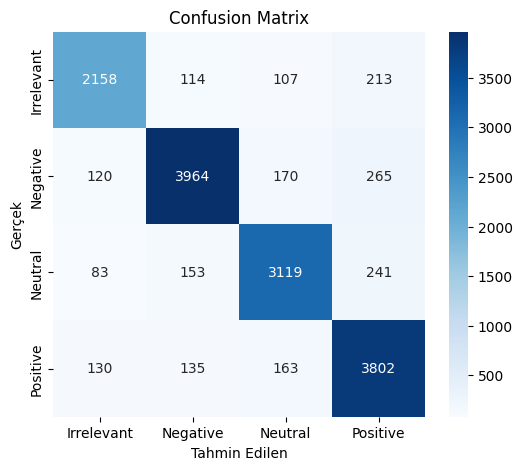

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. X ve y tanımla
x = df_train['tokens'].apply(lambda tokens: ' '.join(tokens))  # Listeyi string'e çevir
y = df_train['duygu_durumu']

# 2. TF-IDF vektörleştirme
vectorizer = TfidfVectorizer()
X_vect = vectorizer.fit_transform(x)

# 3. Eğitim ve test verilerine ayır
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.2, random_state=42)

# 4. MLP modelini tanımla ve eğit
mlp = MLPClassifier(hidden_layer_sizes=(64,), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

# 5. Tahmin yap
y_pred = mlp.predict(X_test)

# 6. Confusion matrix ve classification report
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print("Classification Report:\n", cr)

# 7. Confusion Matrix Görselleştirme
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=mlp.classes_, yticklabels=mlp.classes_)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix')
plt.show()


Bag Of words

BoW Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.91      0.84      0.87      2592
    Negative       0.90      0.90      0.90      4519
     Neutral       0.83      0.91      0.87      3596
    Positive       0.91      0.87      0.89      4230

    accuracy                           0.89     14937
   macro avg       0.89      0.88      0.88     14937
weighted avg       0.89      0.89      0.89     14937



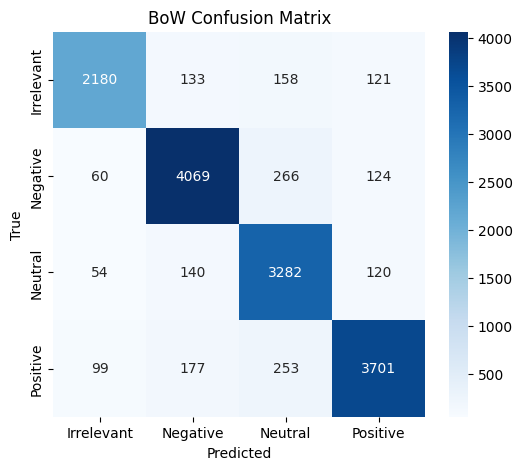

In [29]:
from sklearn.feature_extraction.text import CountVectorizer

# 1. Prepare data
x = df_train['tokens'].apply(lambda tokens: ' '.join(tokens))
y = df_train['duygu_durumu']

# 2. BoW vectorization
vectorizer = CountVectorizer(ngram_range=(1, 2))  # Using unigrams and bigrams
X_vect = vectorizer.fit_transform(x)

# 3. Split data
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.2, random_state=42)

# 4. Train MLP
mlp = MLPClassifier(hidden_layer_sizes=(64,), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

# 5. Predict and evaluate
y_pred = mlp.predict(X_test)
print("BoW Classification Report:\n", classification_report(y_test, y_pred))

# Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=mlp.classes_, yticklabels=mlp.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('BoW Confusion Matrix')
plt.show()

Word 2 vec

Word2Vec Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.46      0.42      0.44      2592
    Negative       0.65      0.70      0.67      4519
     Neutral       0.54      0.54      0.54      3596
    Positive       0.62      0.60      0.61      4230

    accuracy                           0.58     14937
   macro avg       0.57      0.56      0.56     14937
weighted avg       0.58      0.58      0.58     14937



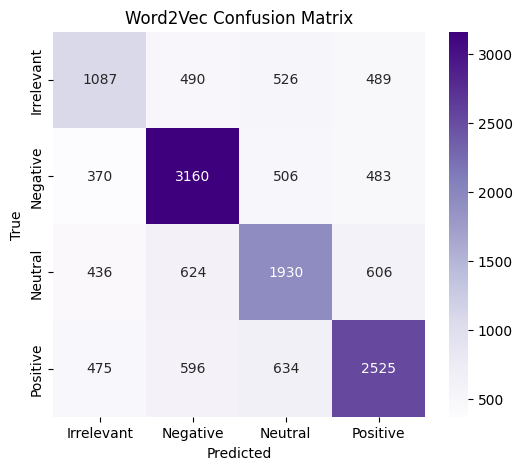

In [32]:
from gensim.models import Word2Vec
import numpy as np

# 1. Train Word2Vec model
sentences = [word_tokenize(text) for text in df_train['tokens'].apply(lambda x: ' '.join(x))]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# 2. Create sentence vectors by averaging word vectors
def sentence_vector(sentence):
    words = word_tokenize(sentence)
    vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(w2v_model.vector_size)

x = df_train['tokens'].apply(lambda tokens: ' '.join(tokens))
X_vect = np.array([sentence_vector(text) for text in x])

# 3. Split data
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.2, random_state=42)

# 4. Train MLP
mlp = MLPClassifier(hidden_layer_sizes=(64,), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

# 5. Predict and evaluate
y_pred = mlp.predict(X_test)
print("Word2Vec Classification Report:\n", classification_report(y_test, y_pred))

# Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=mlp.classes_, yticklabels=mlp.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Word2Vec Confusion Matrix')
plt.show()

GloVe

GloVe Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.52      0.38      0.44      2592
    Negative       0.65      0.69      0.67      4519
     Neutral       0.60      0.50      0.55      3596
    Positive       0.58      0.72      0.64      4230

    accuracy                           0.60     14937
   macro avg       0.59      0.57      0.57     14937
weighted avg       0.60      0.60      0.59     14937



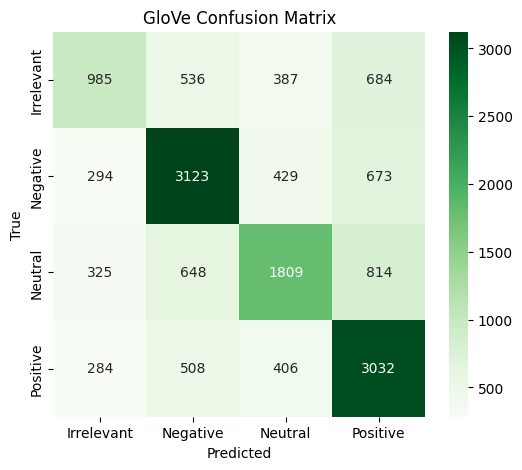

In [34]:
import gensim.downloader as api

# 1. Load pre-trained GloVe model
glove_model = api.load("glove-wiki-gigaword-100")  # 100-dimensional vectors

# 2. Create sentence vectors
def glove_sentence_vector(sentence):
    words = word_tokenize(sentence)
    vectors = [glove_model[word] for word in words if word in glove_model]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

x = df_train['tokens'].apply(lambda tokens: ' '.join(tokens))
X_vect = np.array([glove_sentence_vector(text) for text in x])

# 3. Split data
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.2, random_state=42)

# 4. Train MLP
mlp = MLPClassifier(hidden_layer_sizes=(64,), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

# 5. Predict and evaluate
y_pred = mlp.predict(X_test)
print("GloVe Classification Report:\n", classification_report(y_test, y_pred))

# Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=mlp.classes_, yticklabels=mlp.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('GloVe Confusion Matrix')
plt.show()

FastText

FastText Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.46      0.25      0.32      2592
    Negative       0.62      0.66      0.64      4519
     Neutral       0.49      0.55      0.52      3596
    Positive       0.56      0.61      0.58      4230

    accuracy                           0.55     14937
   macro avg       0.53      0.52      0.52     14937
weighted avg       0.54      0.55      0.54     14937



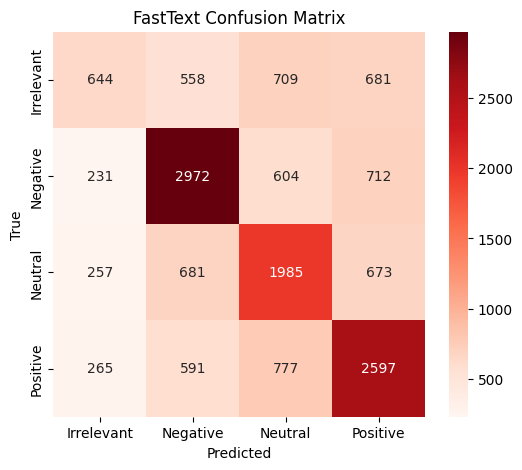

In [38]:
from gensim.models import FastText

# 1. Train FastText model
sentences = [word_tokenize(text) for text in df_train['tokens'].apply(lambda x: ' '.join(x))]
ft_model = FastText(sentences, vector_size=100, window=5, min_count=1, workers=4)

# 2. Create sentence vectors
def fasttext_sentence_vector(sentence):
    words = word_tokenize(sentence)
    vectors = [ft_model.wv[word] for word in words if word in ft_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(ft_model.vector_size)

x = df_train['tokens'].apply(lambda tokens: ' '.join(tokens))
X_vect = np.array([fasttext_sentence_vector(text) for text in x])

# 3. Split data
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.2, random_state=42)

# 4. Train MLP
mlp = MLPClassifier(hidden_layer_sizes=(64,), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

# 5. Predict and evaluate
y_pred = mlp.predict(X_test)
print("FastText Classification Report:\n", classification_report(y_test, y_pred))

# Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=mlp.classes_, yticklabels=mlp.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('FastText Confusion Matrix')
plt.show()